In [12]:
import torch
import numpy as np
from typing import Tuple, Optional

In [13]:
class VeryTinyNerfModel(torch.nn.Module):
    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [14]:
def load_data(path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    _ = np.load(path)
    return _["images"], _["poses"], _["focal"]

In [15]:
def create_rays(width: int, height: int, focal: float, pose: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    ii, jj = torch.meshgrid(torch.arange(start=- width * .5, end=width * .5, step=1.).to(pose),
                            torch.arange(start=- height * .5, end=height * .5, step=1.).to(pose), indexing="xy")
    directions = torch.stack([ii / focal, -jj / focal, -torch.ones_like(ii)], dim=-1)
    ray_directions = torch.matmul(directions, pose[:3, :3].T)
    ray_origins = pose[:3, -1].expand(ray_directions.shape)  # expand 不会实际复制数据，只是改变张量的视图（view），因此它比直接 repeat 更高效。
    return ray_origins, ray_directions

In [16]:
def create_sample_points(ray_origins: torch.Tensor, ray_directions: torch.Tensor, near: float, far: float, samples: int,
                         randomize: Optional[bool] = True) -> (torch.Tensor, torch.Tensor):
    depth_values = torch.linspace(near, far, samples).to(ray_origins)
    if randomize is True:
        noise_shape = ray_origins.shape[:-1] + (samples,)
        depth_values = depth_values + torch.rand(noise_shape).to(ray_origins) * (
                far - near) / samples  # 尽可能不要用就地操作，会破坏autograd，而且也没有自动广播
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
    return query_points, depth_values

In [17]:
def positional_encoding(tensor, num_encoding_functions=6, include_input=True) -> torch.Tensor:
    encoding = [tensor] if include_input else []
    frequency_bands = 2.0 ** torch.linspace(
        0.0,
        num_encoding_functions - 1,
        num_encoding_functions,
        dtype=tensor.dtype,
        device=tensor.device,
    )
    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

In [18]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

In [19]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.
    return cumprod

In [20]:
def render_volume_density(
        radiance_field: torch.Tensor,
        ray_origins: torch.Tensor,
        depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                       one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
    alpha = 1. - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map

In [21]:
def one_iter(model, pose: torch.Tensor, focal: float, width: int, height: int, near: float, far: float, chunksize: int,
             num_encoding_functions: int):
    origin, direction = create_rays(width, height, focal, pose)
    points, depth = create_sample_points(origin, direction, near, far, 32)
    points_flatten = points.reshape(-1, 3)
    points_encoded = positional_encoding(points_flatten, num_encoding_functions=num_encoding_functions)
    batches = get_minibatches(points_encoded, chunksize=chunksize)

    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)
    unflattened_shape = list(points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)
    rgb_predicted, _, _ = render_volume_density(radiance_field, origin, depth)
    return rgb_predicted

Loss: 0.05607215315103531


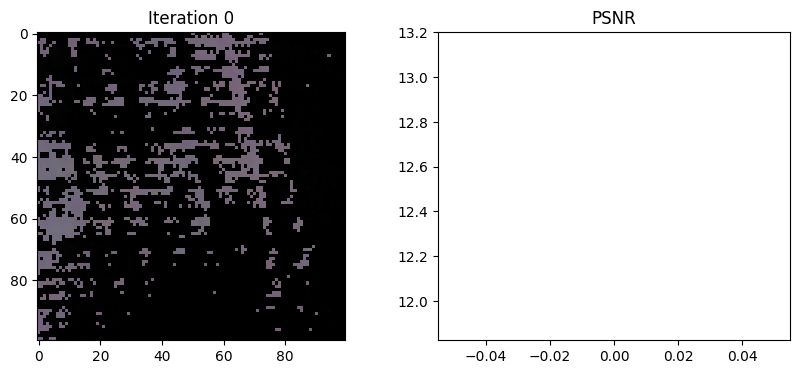

Loss: 0.02785327658057213


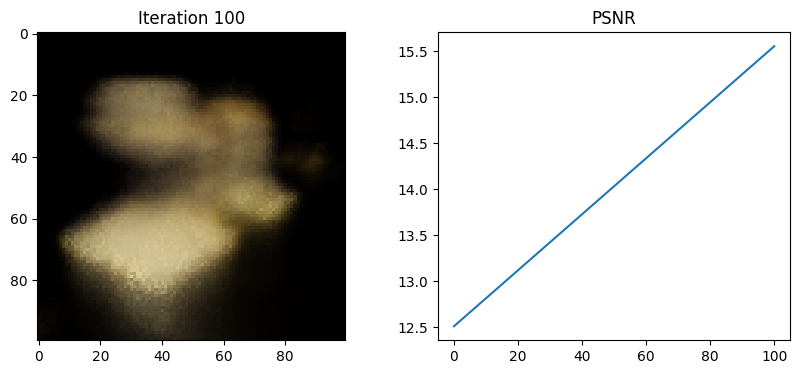

Loss: 0.01026055309921503


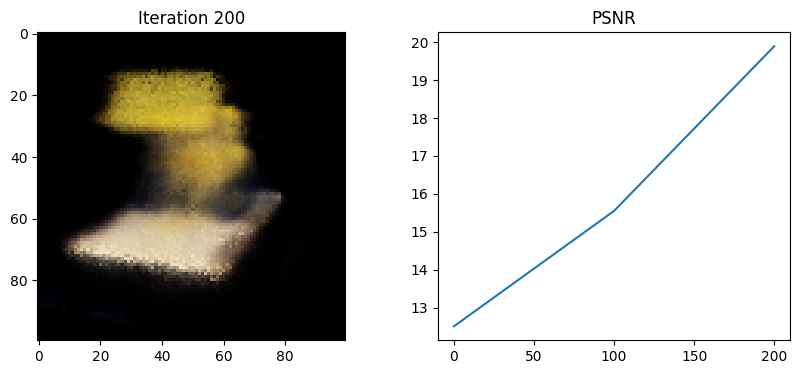

Loss: 0.007853802293539047


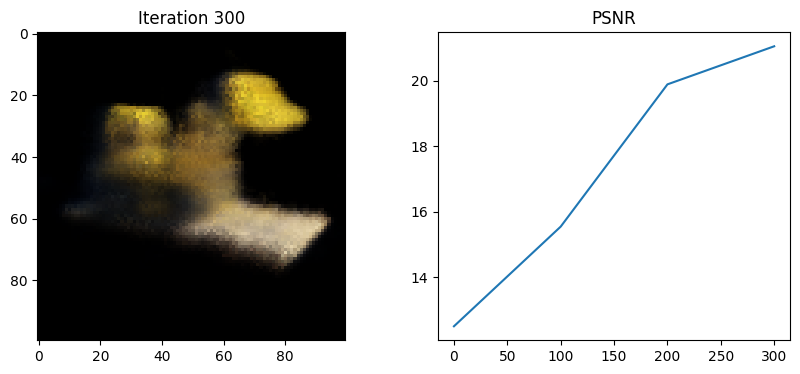

Loss: 0.011564183048903942


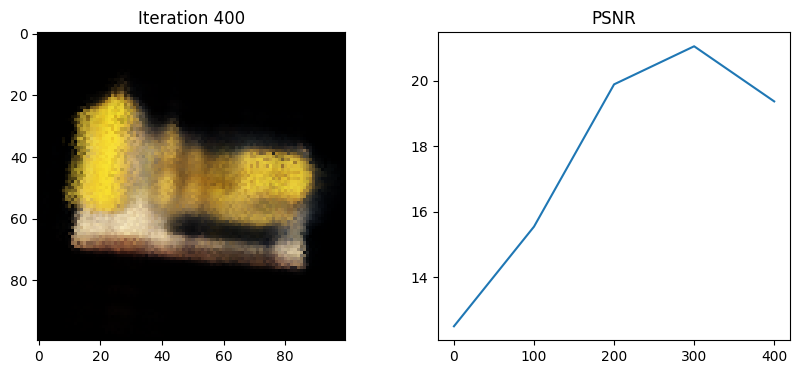

Loss: 0.010086026974022388


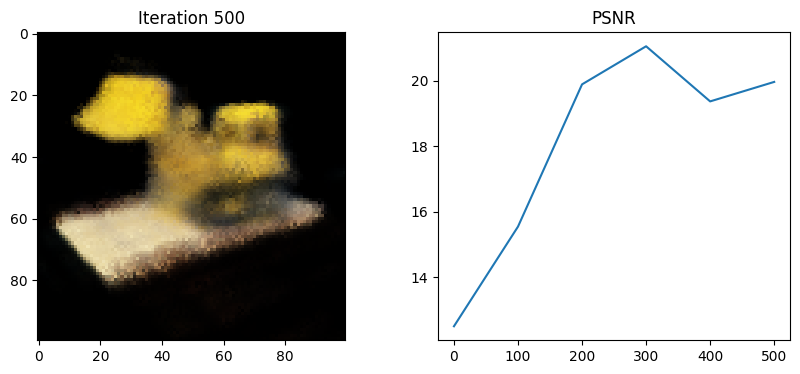

Loss: 0.007779683452099562


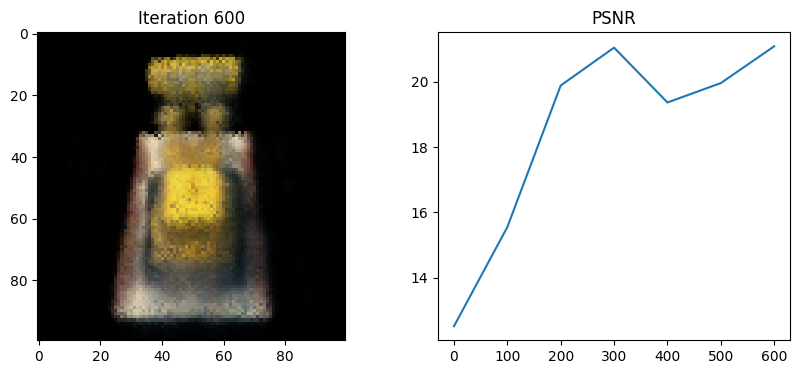

Loss: 0.009368239901959896


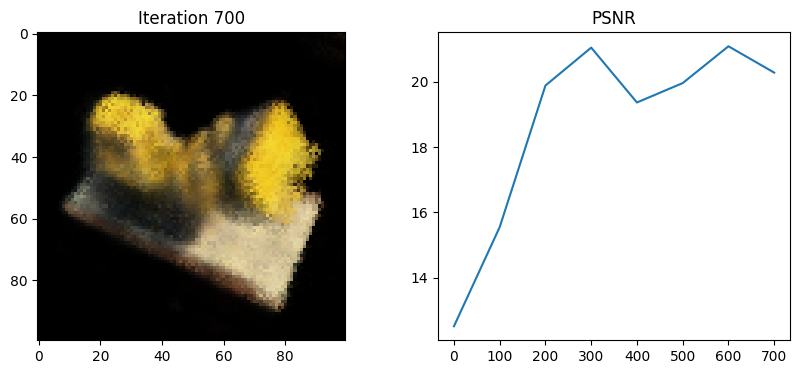

Loss: 0.008454643189907074


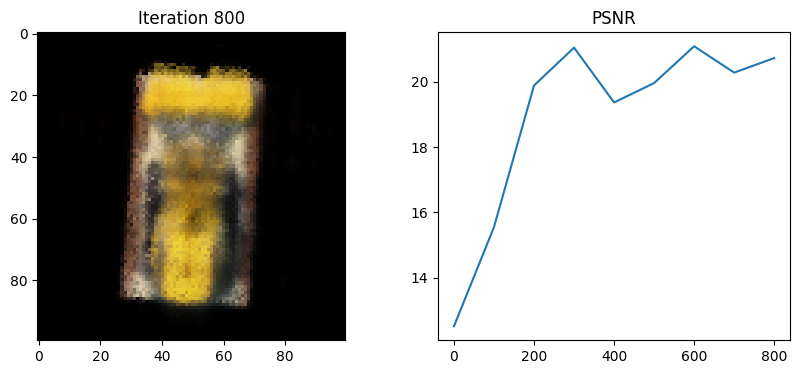

Loss: 0.008719791658222675


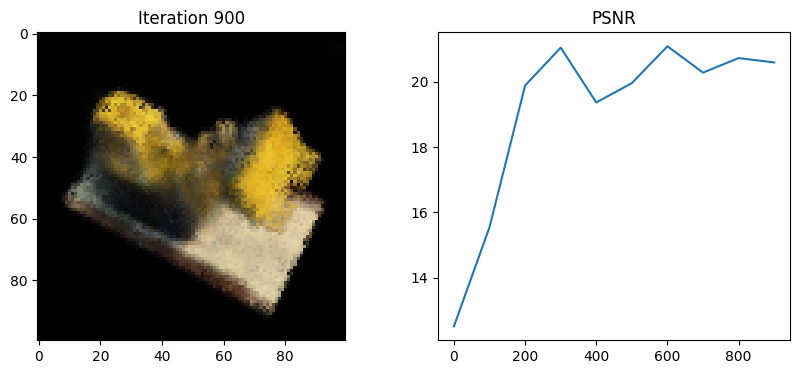

In [22]:
LR = 5e-3
NEAR = 2.
FAR = 6.
NEF = 6
CHUNK_SIZE = 1024 * 16
DEVICE = torch.device("cuda")
IMAGES, POSES, FOCAL = load_data("tiny_nerf_data.npz")
MODEL = VeryTinyNerfModel(num_encoding_functions=NEF)
MODEL.to(DEVICE)
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=LR)
HEIGHT, WIDTH = IMAGES.shape[1:3]

psnrs = []
iternums = []
for i in range(1000):
    _idx = np.random.randint(IMAGES.shape[0])
    _img = torch.from_numpy(IMAGES[_idx]).to(DEVICE)
    _pose = torch.from_numpy(POSES[_idx]).to(DEVICE)
    _rgb_predicted = one_iter(MODEL, _pose, float(FOCAL), WIDTH, HEIGHT, NEAR, FAR, CHUNK_SIZE, NEF)
    _loss = torch.nn.functional.mse_loss(_rgb_predicted, _img)
    _loss.backward()
    OPTIMIZER.step()
    OPTIMIZER.zero_grad()

In [23]:
# import plotly.graph_objects as go
# 
# points_np = points.reshape(-1, 3).numpy()
# x = points_np[:, 0]
# y = points_np[:, 1]
# z = points_np[:, 2]
# 
# fig = go.Figure(data=[go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=2,  # 设置点的大小
#         color=z,  # 使用 z 轴数据来设置颜色
#         colorscale='Viridis',  # 使用 Viridis 颜色映射
#         opacity=0.8  # 设置透明度
#     )
# )])
# 
# fig.update_layout(
#     title="3D Scatter Plot of Points",
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     ),
#     margin=dict(l=0, r=0, b=0, t=0)  # 去除图形的外边距
# )
# 
# fig.show()